# 前処理

In [50]:
import json
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/Users/runble1/.pyenv/versions/3.6.1/envs/lambda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


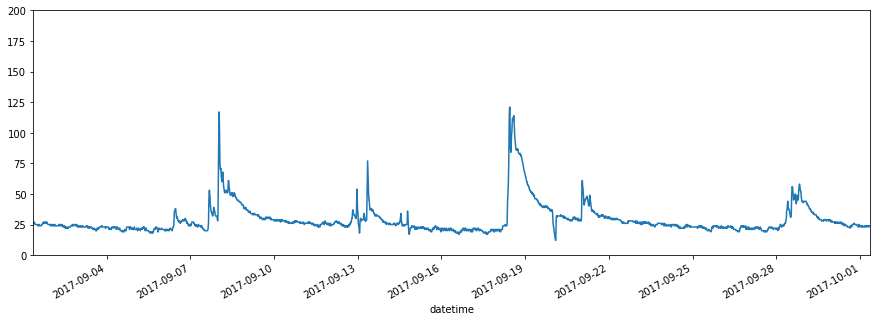

In [133]:
# メートルからセンチメートルへ変換（×100）
df_level_all = pd.read_json("waterLevelSeptember.json")
df_level_all = df_level_all.set_index('datetime')
df_level_all.index = df_level_all.index.tz_localize('UTC')
df_level_all.index = df_level_all.index.tz_convert('Asia/Tokyo')
df_level_all.index = df_level_all.index.tz_localize(None)
df_level = df_level_all.loc[
   (df_level_all['level'] != '-') 
    & (df_level_all['level'] != '&&nbsp;1.10')
    & (df_level_all['level'] != '&&nbsp;1.41')]
df_level["level"] = df_level["level"].astype(np.float64) * 100
df_level["level"].plot(figsize=(15,5), ylim=(0,200))

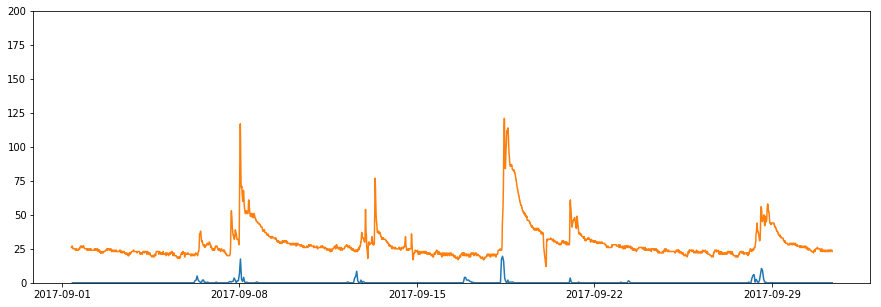

In [134]:
# ミリ
filename = "rainfall09.csv"
df = pd.read_csv(filename,encoding="SHIFT-JIS",skiprows=4)
df_rain = df.iloc[:,0:2]
df_rain.columns = ["timestamp", "rain"]
df_rain["timestamp"] = df_rain.timestamp.map(lambda _: pd.to_datetime(_))
df_rain = df_rain.set_index('timestamp')
df_rain.index = df_rain.index.tz_localize('UTC')
df_rain.index = df_rain.index.tz_convert('Asia/Tokyo')
df_rain.index = df_rain.index.tz_localize(None)
plt.figure(figsize=(15,5))
plt.ylim(0,200)
plt.plot(df_rain.rain)
plt.plot(df_level.level )

In [135]:
# 降水量の期間(1年)を水位の期間(1ヶ月)に合わせる
df_rain = df_rain[df_rain.index < df_level.index.max()]
df_rain.tail()

,rain
timestamp,
2017-10-01 04:00:00,0.0
2017-10-01 05:00:00,0.0
2017-10-01 06:00:00,0.0
2017-10-01 07:00:00,0.0
2017-10-01 08:00:00,0.0


In [136]:
df_rain = df_rain[df_rain.index > df_level.index.min()]
df_rain.head()

,rain
timestamp,
2017-09-01 10:00:00,0.0
2017-09-01 11:00:00,0.0
2017-09-01 12:00:00,0.0
2017-09-01 13:00:00,0.0
2017-09-01 14:00:00,0.0


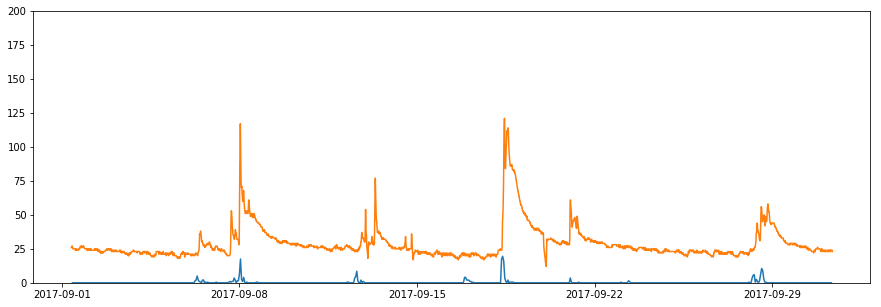

In [137]:
plt.figure(figsize=(15,5))
plt.ylim(0,200)
plt.plot(df_rain.rain)
plt.plot(df_level.level)

In [138]:
'''
1時間前の水位の変化と降水量から、1時間後の最大水位を予測する
60分に7点データ(1/1 00:00:00 ~ 1/1 01:00:00)ある
欠損(NaN)を考えると6点データが限界？
降水量のtimestampは１時間前のものである
'''
ixs = df_rain.index

df = []
y = []

for i in range(len(ixs)-3):

    dt1 = ixs[i + 1]
    dt2 = ixs[i + 2]
    dt3 = ixs[i + 3]

    d1 = df_level[dt1:dt2].level.tolist()
    d2 = df_level[dt2:dt3].level.tolist()

    # 7以下でNaNが含まれず、かつ、なるべく多くのデータをとりたい
    # とりあえず5
    if len(d1) > 5 and len(d2) > 5:
        y.append(max(d2))
        d1.sort()
        d1.reverse()
        d1 = d1[:5]
        d1.append(df_rain.ix[i].rain)
        df.append(d1)
        
df = pd.DataFrame(df)
df['y'] = y

df.shape

/Users/runble1/.pyenv/versions/3.6.1/envs/lambda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


(349, 7)

In [139]:
df

,0,1,2,3,4,5,y
0,25.0,25.0,25.0,25.0,25.0,0.0,25.0
1,25.0,25.0,25.0,25.0,24.0,0.0,25.0
2,25.0,25.0,25.0,24.0,24.0,0.0,25.0
3,25.0,25.0,24.0,24.0,24.0,0.0,25.0
4,25.0,24.0,24.0,24.0,24.0,0.0,26.0
5,26.0,25.0,25.0,25.0,25.0,0.0,27.0
6,27.0,27.0,26.0,26.0,26.0,0.0,27.0
7,25.0,25.0,25.0,25.0,25.0,0.0,25.0
8,25.0,25.0,25.0,25.0,24.0,0.0,25.0
9,25.0,25.0,25.0,25.0,25.0,0.0,25.0


# 機械学習

In [140]:
X_cols = df.columns[:-1]
X_cols

Index([0, 1, 2, 3, 4, 5], dtype='object')

In [141]:
# データを入力と出力に分割
X = df[X_cols].as_matrix().astype("float")
y = df.y.as_matrix().astype("int").flatten()

In [142]:
# 7割を学習データ、3割を検証データに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
#num = int(len(X) * 0.9)
#print(len(X), num, len(X)-num)

#X_train = X[:num]
#X_test = X[num:]
#y_train = y[:num]
#y_test = y[num:]

(314, 6)
(35, 6)
(314,)
(35,)


In [143]:
# スケール変換前の標準偏差を確認
X_train.std()

13.502788172765149

In [144]:
# スケール変換、標準偏差を求める
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# スケール変換器の適合
scaler.fit(X_train)

# スケール変換
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.std()

0.14136607641584678

In [145]:
# モデルの設定

# ランダムフォレスト
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=42)

# 勾配ブースティング
#from sklearn.ensemble import GradientBoostingRegressor
#model = GradientBoostingRegressor(random_state=42)

# ニューラルネットワーク
#from sklearn.neural_network import MLPRegressor
#model = MLPRegressor(random_state=42)

model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [146]:
# 学習と予測
model.fit(X_train_scaled, y_train)
result = model.predict(X_test)
result.shape

(35,)

In [147]:
# スコア
print(model.score(X_test_scaled,y_test))

0.932984973532


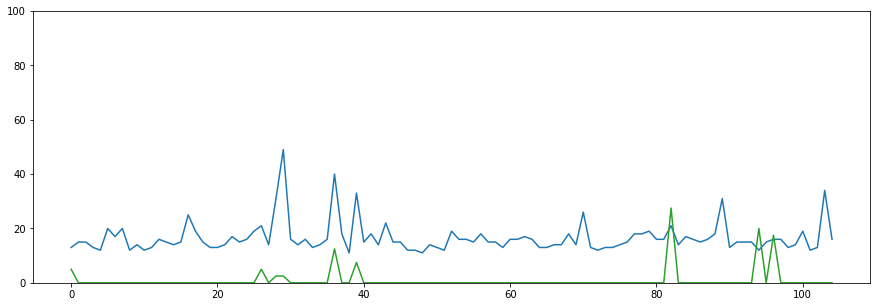

In [125]:
pp = pd.DataFrame({'act': np.array(y_test), "pred": np.array(result), "rain": X_test[:,-1]})
#pp = pd.DataFrame({"pred": np.array(result), "rain": X_test[:,-1]})
pp.rain = pp.rain * 5
plt.figure(figsize=(15,5))
plt.ylim(0,100)
plt.legend = pp.columns
plt.plot(pp)